In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import pandas_market_calendars as mcal
import datetime
import math

In [60]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=5400) #15 years analysis
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol
Russell_1000_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/Russell_1000_Index')[3].Symbol
SnP600_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["SPY"]

tickers = final_ticker(SnP_componet_ticker)
def Get_Average_price(tickers, start_date):
    data = yf.download(tickers,start = start_date)
    print('Removing ticker with nan values')
    data = data.dropna(axis=1, how='any')
    print('Calculating average price')
    data = (data['Open'] + data['Close'] + data['High'] + data['Low']) / 4
    if len(tickers) > 1:
        ava_ticker = list(data.columns)
        assert len(ava_ticker) == len(data.columns)
        return data, ava_ticker
    else:
        return data

df,tickers = Get_Average_price(tickers,valid_start_day)
df_BM = Get_Average_price(index_banch_mart, valid_start_day)
number_of_stocks = df.shape[1]

[**********************54%%                      ]  274 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2010-02-16 -> 2024-11-27)


[*********************100%%**********************]  503 of 503 completed

69 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2010-02-16 -> 2024-11-27)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['MCD', 'PNW', 'PEG', 'CCI', 'BBY', 'UDR', 'MTD', 'MET', 'GEHC', 'UNP', 'MAR', 'CBOE', 'DIS', 'EQIX', 'RVTY', 'PFG', 'EA', 'PEP', 'DXCM', 'ECL', 'EQR', 'ALL', 'FRT', 'EMN', 'TSLA', 'MCK', 'CFG', 'GPN', 'MMC', 'ADSK', 'CNP', 'VICI', 'CMS', 'MRK', 'NXPI', 'PNR', 'HPQ', 'WAT', 'CHD', 'CB', 'BG', 'MU', 'WFC', 'MSCI', 'LVS', 'LULU', 'HST', 'DOW', 'SBAC', 'GEN', 'STT', 'MNST', 'USB', 'RF', 'GE', 'GEV', 'NDSN', 'NEM', 'TJX', 'STZ', 'FDS', 'MTCH', 'HII', 'AMD', 'NTAP', 'V', 'GILD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Removing ticker with nan values
Calculating average price


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SPY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Removing ticker with nan values
Calculating average price


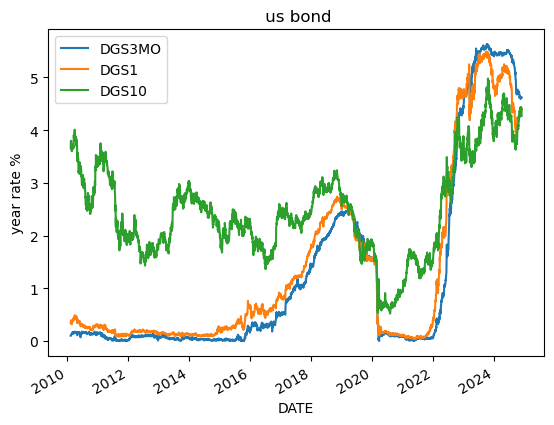

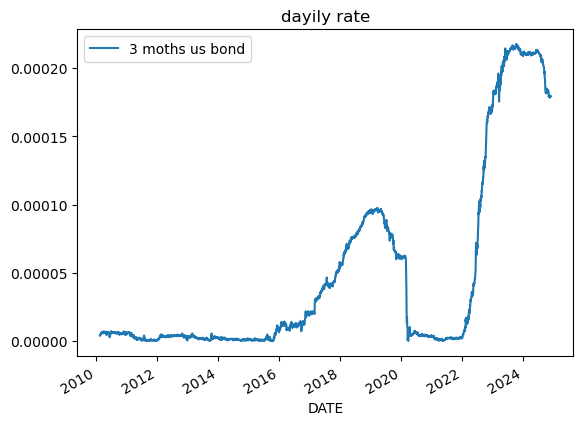

In [3]:
US_TB = ['DGS3MO', 'DGS1', 'DGS10'] #3 months, 1 year, 10 years

df_bonds = pdr.DataReader(US_TB, 'fred', valid_start_day, valid_end_day).dropna()
df_bonds["3month_cts_rate"] = (1+df_bonds["DGS3MO"]/100)**(1/252) -1 
risk_free_rate = df_bonds["3month_cts_rate"]

df_bonds["DGS3MO"].plot(title = " us bond", ylabel="year rate %")
#df_bonds["3month_cts_rate"].plot()
df_bonds["DGS1"].plot( )
df_bonds["DGS10"].plot( )
plt.legend()
plt.show()

risk_free_rate.plot(label = "3 moths us bond", title="dayily rate")
#df_bonds["3month_cts_rate"].plot()
plt.legend()
plt.show()

In [64]:
ret_df = np.log(df/df.shift(1)).dropna()
ret_df_BM = np.log(df_BM/df_BM.shift(1)).dropna()

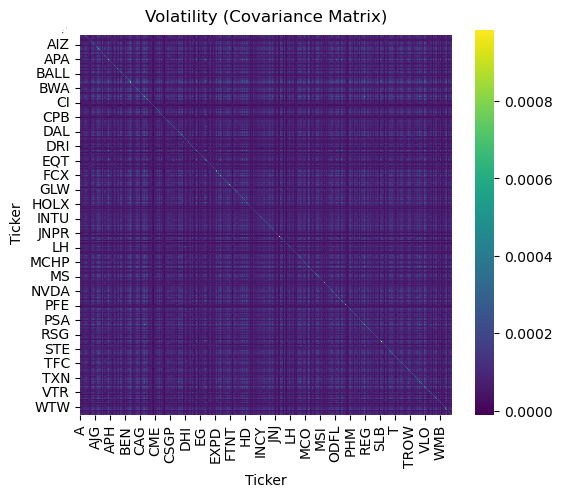

In [66]:
Covarian_matrix = ret_df.cov()
plt.figure(figsize=(6, 5))
sns.heatmap(Covarian_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Volatility (Covariance Matrix)')
plt.show()

Optimization Time

In [94]:
def Sharpe_pf(Weight,return_df,risk_free_rate):
    pf_risk = np.sqrt(Weight.dot(return_df.cov().dot(Weight)))
    pf_mean = return_df.mean().dot(Weight)
    if type(risk_free_rate) != int:
        risk_free_rate = risk_free_rate.mean()
    return -(pf_mean-risk_free_rate)/pf_risk

def Sortino_pf(Weight, return_df, benchmark_df):
    pf_return = return_df.dot(Weight)
    
    if isinstance(benchmark_df, (int, float)): # you can use an ETF or just the rfr
        benchmark_return = benchmark_df
    else:
        benchmark_return = benchmark_df.mean()
    
    downside_deviation = np.sqrt(
        np.mean(
            np.minimum(0, pf_return - benchmark_return) ** 2
        )
    )
    pf_mean = pf_return.mean()
    
    if downside_deviation == 0:
        return np.inf if pf_mean > benchmark_return else -np.inf
    return -(pf_mean - benchmark_return) / downside_deviation

def Ulcer_pf(Weight, return_df, risk_free_rate):
    cumulative_returns = (1 + return_df.dot(Weight)).cumprod()

    max_cumulative_returns = cumulative_returns.cummax()
    
    drawdowns = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns * 100
    
    ulcer_index = np.sqrt(np.mean(drawdowns ** 2))
    
    return ulcer_index

In [96]:
def Expected_return(Weight,return_df):
    return return_df.dot(Weight).cumsum().dropna()

In [98]:
T_fraction = 0.92 # ( 11/12, hold 1 month)
def split_train_test(df,BM,rfr,Fraction):
    def Log_return(df):
        return np.log(df/df.shift(1)).dropna()
    
    common_indices = df.index.intersection(rfr.index)
    df = df.loc[common_indices]
    common_indices = BM.index.intersection(rfr.index)

    df = df.loc[common_indices]
    rfr = rfr.loc[common_indices]
    BM = BM.loc[common_indices]

    matched_len = len(df)
    Train_len = int(matched_len*Fraction)
    
    train = Log_return(df[:Train_len])
    test = Log_return(df[Train_len:])
    rfr = np.log((1+rfr)) #Risk-Free Return (Log)
    
    BM_train = Log_return(BM[:Train_len])
    BM_test = Log_return(BM[Train_len:])

    rfr_train = rfr[:Train_len]
    rfr_test = rfr[Train_len:]

    return train, BM_train, rfr_train, test, BM_test, rfr_test 

Train, BM_train, Train_rfr, Test, BM_test, Test_rfr = split_train_test(df, df_BM, risk_free_rate, T_fraction)
BM = pd.concat([BM_train,BM_test])

In [100]:
def Fit_weight(method,N_stock,log_return,rfr):
    W_int = np.ones(N_stock)/N_stock
    cons = ({"type":"eq", "fun":lambda x:np.sum(x) - 1})
    
    Train_result = minimize(method,W_int,args=(log_return,rfr), bounds=Bounds(0,1),constraints = cons)
    W_opt_train = Train_result["x"]
    return W_opt_train

In [102]:
W_sharpe_ratio_train = Fit_weight(Sharpe_pf,number_of_stocks,Train,Train_rfr)
W_Sortino_ratio_train = Fit_weight(Sortino_pf,number_of_stocks,Train,BM_train)
W_Ulcer_index_train = Fit_weight(Ulcer_pf,number_of_stocks,Train,Train_rfr)
W_0 = np.ones(number_of_stocks)/number_of_stocks

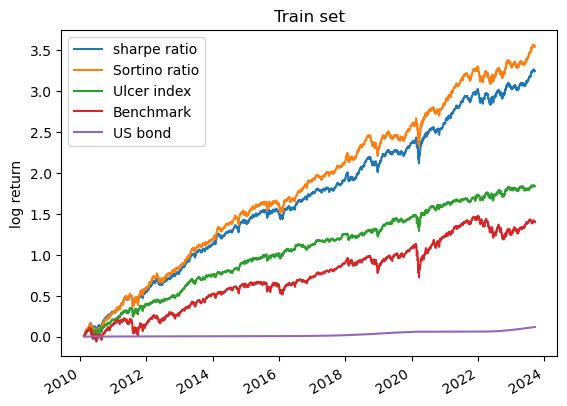

In [103]:
ER_sharp_ratio_train  = Expected_return(W_sharpe_ratio_train,Train)
ER_Sortino_ratio_train  = Expected_return(W_Sortino_ratio_train,Train)
ER_Ulcer_index_train  = Expected_return(W_Ulcer_index_train,Train)

ER_sharp_ratio_train.plot(title="Train set",ylabel="log return",label="sharpe ratio")
ER_Sortino_ratio_train.plot(label="Sortino ratio")
ER_Ulcer_index_train.plot(label="Ulcer index")
BM_train.cumsum().plot(label="Benchmark")
Train_rfr.cumsum().plot(label="US bond")
plt.legend()
plt.show()

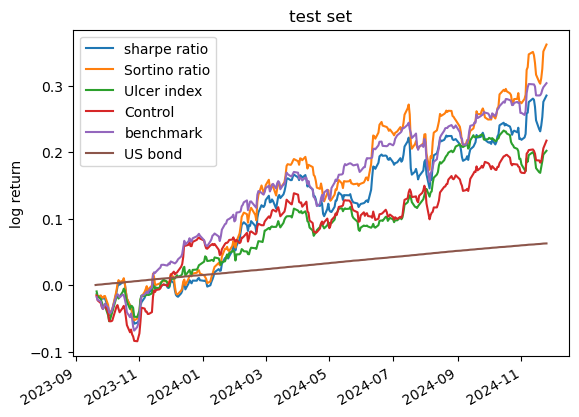

In [104]:
ER_sharpe_ratio_Test  = Expected_return(W_sharpe_ratio_train,Test)
ER_Sortino_ratio_Test  = Expected_return(W_Sortino_ratio_train,Test)
ER_Ulcer_index_Test  = Expected_return(W_Ulcer_index_train,Test)

ER_sharpe_ratio_final = ER_sharpe_ratio_Test.iloc[-1]
ER_Sortino_ratio_final = ER_Sortino_ratio_Test.iloc[-1]
ER_Ulcer_index_final = ER_Ulcer_index_Test.iloc[-1]


ER_control = Expected_return(W_0,Test)
ER_control_final = ER_control.iloc[-1]

BM_cumsum_final = BM_test.cumsum().iloc[-1]

ER_sharpe_ratio_Test.plot(title="test set",ylabel="log return",label="sharpe ratio")
ER_Sortino_ratio_Test.plot(label="Sortino ratio")
ER_Ulcer_index_Test.plot(label="Ulcer index")

ER_control.plot(label="Control")
BM_test.cumsum().plot(label="benchmark")
((1+Test_rfr).cumprod()-1).plot(label="US bond")
plt.legend()
plt.show()

In [105]:
print('Return for the test data are:')

print(f'Sharpe ratio: {np.exp(ER_sharpe_ratio_final):.2f}%')
print(f'Sortine ratio: {np.exp(ER_Sortino_ratio_final):.2f}%')
print(f'Ulcer index: {np.exp(ER_Ulcer_index_final):.2f}%')
print(f"Control return: {np.exp(ER_control_final):.2f}%")

print(f"Benchmark return is {BM_cumsum_final*100:.2f}%")
print(f"US bond return is {Test_rfr.iloc[-1]*100:2f}%")

Return for the test data are:
Sharpe ratio: 1.33%
Sortine ratio: 1.44%
Ulcer index: 1.22%
Control return: 1.24%
Benchmark return is 30.41%
US bond return is 0.017922%


In [106]:
def What_Should_I_buy(Ticker,Weight):
    buy_list = {}
    lower_limit = 0.01
    Weight_adj = [X if X >= lower_limit else 0 for X in Weight]
    Weight_og = Weight_adj
    Weight_adj = 1/sum(Weight_adj)*np.array(Weight_adj)
    
    print(f"The threshold is {lower_limit}")
    print("you should buy:")
    
    for T, W in zip(Ticker, Weight_adj):
        if W > lower_limit:
            buy_list[T] = W
            print(f"W_{T} =  {W:.2f}")
    print("------------------------------")
    print(f"Sum to {sum(Weight_og)}")
    print("==============================")
    return buy_list

print("For the test set")
print("==============================")
print('Sharpe ratio:')
Test_buy_list_sharpe_ratio = What_Should_I_buy(tickers,W_sharpe_ratio_train)
print('Sortino ratio:')
Test_buy_list_Sortino_ratio = What_Should_I_buy(tickers,W_Sortino_ratio_train)
print('Ulcer index:')
Test_buy_list_Sortino_ratio = What_Should_I_buy(tickers,W_Ulcer_index_train)


For the test set
Sharpe ratio:
The threshold is 0.01
you should buy:
W_AZO =  0.06
W_CDNS =  0.06
W_CHTR =  0.01
W_DPZ =  0.13
W_ERIE =  0.03
W_FICO =  0.02
W_HSY =  0.05
W_LLY =  0.20
W_NFLX =  0.02
W_ODFL =  0.10
W_ORLY =  0.12
W_REGN =  0.03
W_TPL =  0.11
W_WST =  0.05
------------------------------
Sum to 0.9789003226658262
Sortino ratio:
The threshold is 0.01
you should buy:
W_CDNS =  0.08
W_DPZ =  0.17
W_FICO =  0.03
W_LLY =  0.18
W_NVDA =  0.04
W_ODFL =  0.16
W_ORLY =  0.15
W_REGN =  0.05
W_TPL =  0.14
------------------------------
Sum to 0.9912955634437128
Ulcer index:
The threshold is 0.01
you should buy:
W_AAPL =  0.01
W_ACGL =  0.01
W_AXON =  0.01
W_CLX =  0.05
W_CPB =  0.04
W_CTRA =  0.05
W_DPZ =  0.01
W_ED =  0.06
W_EQT =  0.01
W_ERIE =  0.07
W_HRL =  0.06
W_HSY =  0.04
W_K =  0.03
W_KDP =  0.02
W_LLY =  0.12
W_MKTX =  0.08
W_NOC =  0.03
W_ODFL =  0.04
W_ORLY =  0.04
W_PGR =  0.06
W_REGN =  0.02
W_ROL =  0.02
W_SO =  0.04
W_TPL =  0.02
W_VZ =  0.06
-----------------------

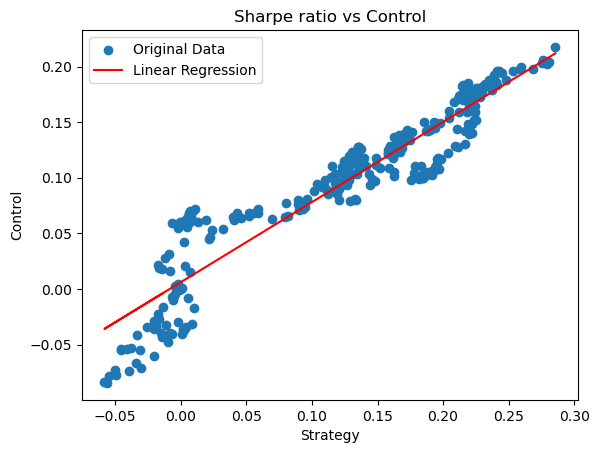

alpha and beta are 0.006, 0.721


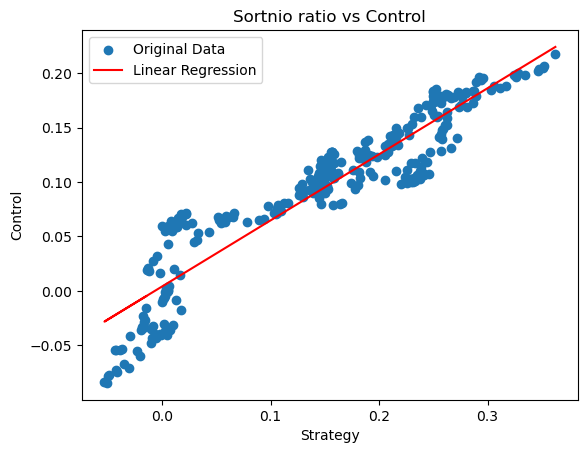

alpha and beta are 0.004, 0.607


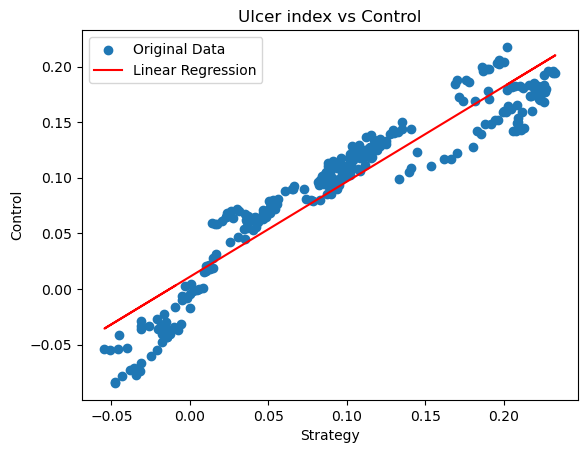

alpha and beta are 0.011, 0.855


In [107]:
import Functions.AlphaBeta as MT
plt.title("Sharpe ratio vs Control")
alpha, beta = MT.AlphaBeta(ER_sharpe_ratio_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Sortnio ratio vs Control")
alpha, beta = MT.AlphaBeta(ER_Sortino_ratio_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Ulcer index vs Control")
alpha, beta = MT.AlphaBeta(ER_Ulcer_index_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")


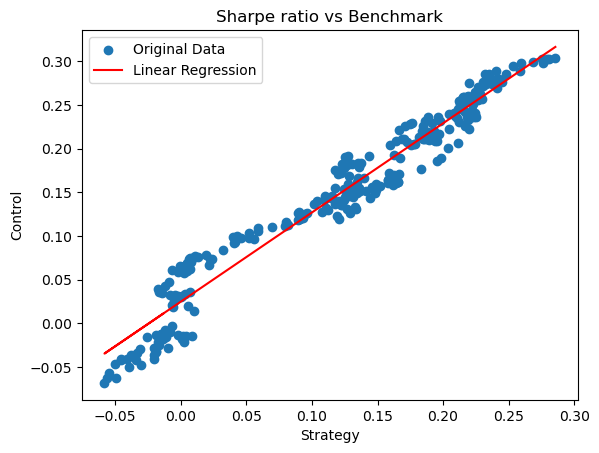

alpha and beta are 0.025, 1.023


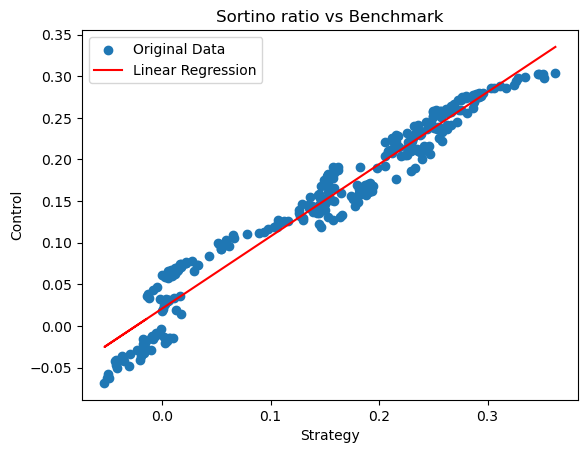

alpha and beta are 0.021, 0.868


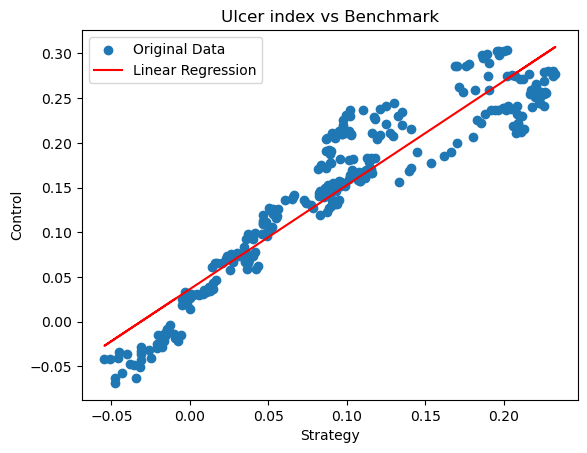

alpha and beta are 0.036, 1.163


In [108]:
plt.title("Sharpe ratio vs Benchmark")
alpha, beta = MT.AlphaBeta(ER_sharpe_ratio_Test.to_list(),BM_test.cumsum().to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Sortino ratio vs Benchmark")
alpha, beta = MT.AlphaBeta(ER_Sortino_ratio_Test.to_list(),BM_test.cumsum().to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Ulcer index vs Benchmark")
alpha, beta = MT.AlphaBeta(ER_Ulcer_index_Test.to_list(),BM_test.cumsum().to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

In [109]:
#W_sharpe_ratio_final = Fit_weight(Sharpe_pf,number_of_stocks,ret_df,np.log(risk_free_rate))
W_Sortino_ratio_final = Fit_weight(Sortino_pf,number_of_stocks,ret_df,BM)
#W_Ulcer_index_final = Fit_weight(Ulcer_pf,number_of_stocks,ret_df,np.log(risk_free_rate))

In [110]:
print("==============================")
print('Sortino ratio:')
Buy_list_Sortino_ratio = What_Should_I_buy(tickers,W_Sortino_ratio_final)

Sortino ratio:
The threshold is 0.01
you should buy:
W_AXON =  0.03
W_DPZ =  0.11
W_FICO =  0.20
W_LLY =  0.15
W_NFLX =  0.03
W_NVDA =  0.12
W_ODFL =  0.03
W_ORLY =  0.14
W_TPL =  0.20
------------------------------
Sum to 1.0000000000000724


['AXON', 'DPZ', 'FICO', 'LLY', 'NFLX', 'NVDA', 'ODFL', 'ORLY', 'TPL']


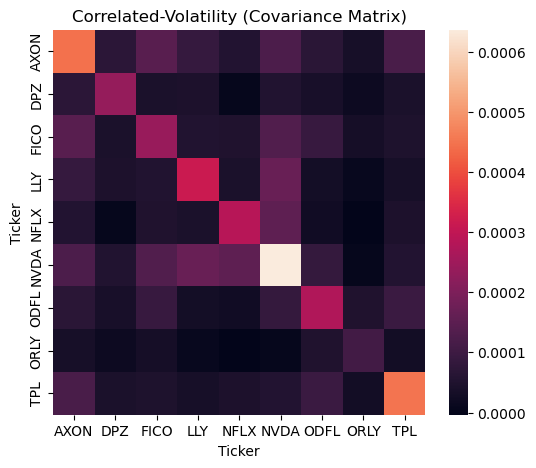

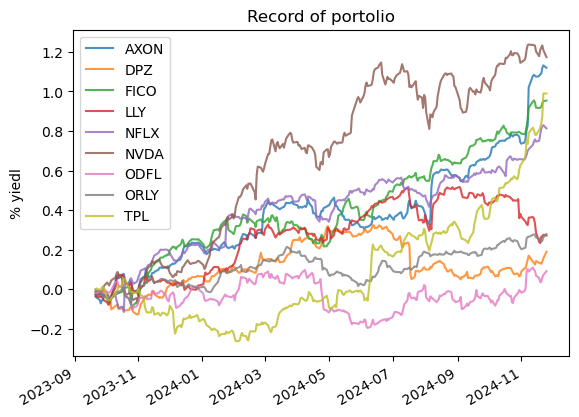

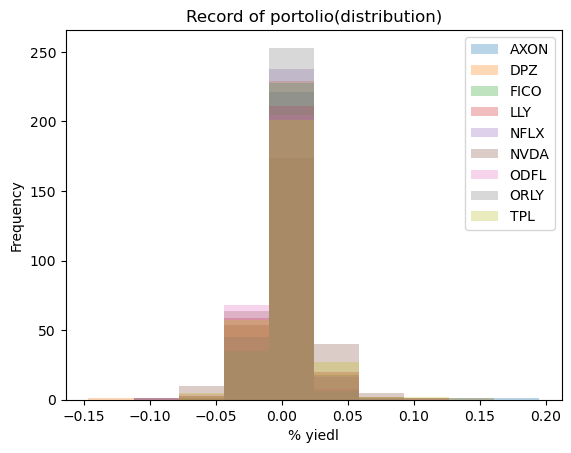

AXON : mean=3.7940e-03, var=4.4405e-04, skewness=4.317
DPZ : mean=6.4146e-04, var=2.3507e-04, skewness=-2.545
FICO : mean=3.2333e-03, var=2.3978e-04, skewness=-0.334
LLY : mean=9.1917e-04, var=3.1557e-04, skewness=-0.004
NFLX : mean=2.7558e-03, var=2.8511e-04, skewness=2.364
NVDA : mean=3.9772e-03, var=6.3627e-04, skewness=0.050
ODFL : mean=3.0844e-04, var=2.7591e-04, skewness=-0.173
ORLY : mean=9.4491e-04, var=1.0777e-04, skewness=0.075
TPL : mean=3.3545e-03, var=4.4974e-04, skewness=1.488


In [111]:
def track_record(your_list):
    ticker = list(your_list.keys())

    print(ticker)
    Covarian_matrix = Test[ticker].cov()
    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(Covarian_matrix, annot=False, fmt=".2e", annot_kws={"size": 9},cbar=True)
    plt.title('Correlated-Volatility (Covariance Matrix)')
    plt.show()

    Test[ticker].cumsum().plot(label=ticker,ylabel="% yiedl",title="Record of portolio", alpha =0.8)
    plt.legend()
    plt.show()

    mean = Test[ticker].mean()
    variance = Test[ticker].var()
    skewness = Test[ticker].skew()

    Test[ticker].plot.hist(label=ticker,xlabel="% yiedl",title="Record of portolio(distribution)",bins=10, alpha =0.3)
    plt.legend()
    plt.show()
    for i in range(len(ticker)):
        print(f"{ticker[i]} : mean={mean.values[i]:.4e}, var={variance.values[i]:.4e}, skewness={skewness.values[i]:.3f}" )


track_record(Buy_list_Sortino_ratio)

In [116]:
def How_much_money_I_need_now(your_list,simple=False):
    ticker = sorted(list(your_list.keys()))
    start_date = valid_end_day  - datetime.timedelta(days=1)
    Avg_price,_ = Get_Average_price(ticker, start_date)
    n_stock = [1]*len(your_list)
    for i in range(len(ticker)):
        n_stock[i] = int(your_list[ticker[i]]*100)
    n_stock = np.array(n_stock)
    GCD = math.gcd(max(n_stock),min(n_stock))
    for i in range(len(n_stock)):
        GCD = math.gcd(GCD,n_stock[i])
    n_stock = n_stock/GCD
    prices = np.array(Avg_price.values[0])
    Need_Cash = sum(n_stock*prices)
    print("Full strategy:")
    print("Buy")
    for T, N in zip(ticker, n_stock):
        print(f"{N} stock of {T} at {Avg_price[T].values[0]:.2f}")
        print(f"portfolio weighting = {N*Avg_price[T].values[0]/Need_Cash*100} %")
        print("---------------------------------------------")
    print(f"Total cash needed is {Need_Cash:.2f} USD")
    print("=================================================")


    if simple:
        rounded_n_stock = np.array([float(round(x/10)) for x in n_stock])
        Need_Cash_simple = sum(rounded_n_stock*prices)
        print("Simple strategy:")
        print("Buy")
        for k in range(len(ticker)):
            print(f"{rounded_n_stock[k]} stock of {ticker[k]} at {Avg_price[ticker[k]].values[0]:.2f}")
            print(f"portfolio weighting = {rounded_n_stock[k]*Avg_price[ticker[k]].values[0]/Need_Cash_simple*100} %")
            print("------------------------------------------------")
        print(f"Total cash(Simple) needed is {Need_Cash_simple:.2f} USD")
    
How_much_money_I_need_now(Buy_list_Sortino_ratio)

[*********************100%%**********************]  9 of 9 completed

Removing ticker with nan values
Calculating average price
Full strategy:
Buy
2.0 stock of AXON at 627.24
portfolio weighting = 1.1040849525267278 %
---------------------------------------------
11.0 stock of DPZ at 470.53
portfolio weighting = 4.555258223806511 %
---------------------------------------------
19.0 stock of FICO at 2369.97
portfolio weighting = 39.63078284869568 %
---------------------------------------------
14.0 stock of LLY at 788.87
portfolio weighting = 9.720025526088863 %
---------------------------------------------
3.0 stock of NFLX at 873.42
portfolio weighting = 2.3061214130420575 %
---------------------------------------------
12.0 stock of NVDA at 137.40
portfolio weighting = 1.4510934272113327 %
---------------------------------------------
3.0 stock of ODFL at 224.35
portfolio weighting = 0.5923557850132344 %
---------------------------------------------
13.0 stock of ORLY at 1236.04
portfolio weighting = 14.142011362152306 %
-------------------------------